# Image Denoising

## Importing Library

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
for i in [1,2,3]:
    try:
        tf.config.experimental.set_memory_growth(tf.config.get_visible_devices()[i], True)
    except:
        pass
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, load_img, img_to_array 
from tensorflow.keras.models import load_model, save_model, Model
from tensorflow.keras.layers import *
import os
from tqdm.notebook import tqdm_notebook as tqdm
from tensorflow.keras.callbacks import *
from skimage.io import imshow, imsave, imread
from skimage.color import gray2rgb, rgb2lab, rgb2gray
from skimage.transform import resize
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tensorflow.keras.initializers import *
from tensorflow.keras.applications import *
from segmentation_models import Unet
import segmentation_models
from prettytable import PrettyTable
!nvidia-smi -L

Segmentation Models: using `tf.keras` framework.
GPU 0: NVIDIA GeForce GTX 1050 Ti (UUID: GPU-7a2eb0f1-f29d-dc70-85d6-ac9df8686b75)
GPU 1: NVIDIA GeForce GTX 1050 Ti (UUID: GPU-9c4b5a58-a4f8-cda7-897f-f77a19360388)
GPU 2: NVIDIA GeForce GTX 1660 SUPER (UUID: GPU-68b71a8f-1517-bdfc-f8c4-0f0913519f9a)


In [9]:
train_dir = r'D:\Datasets\Flowers\train/' 
val_dir = r'D:/Datasets/Flowers/test/' 
img_h = 256
img_w = 256
dim = (img_h, img_w, 3)

## Loading Images and adding Artificial Noise to the Images

In [10]:
train_gen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True, vertical_flip = True)
val_gen = ImageDataGenerator(rescale = 1./255)

In [11]:
def noisy_generator(batches):
    for batch_x in batches:
        sd = np.random.choice([0.052, 0.094, 0.12])
        noise = np.random.normal(scale = sd, size = (batch_x.shape))  
        batch_noisy = batch_x + noise
        batch_noisy = np.clip(batch_noisy, 0, 1)
        yield (batch_noisy, batch_x)

In [12]:
bs = 6
train = train_gen.flow_from_directory(train_dir, class_mode = None, target_size = (img_h, img_w), batch_size = bs)

val = val_gen.flow_from_directory(val_dir, class_mode = None, target_size = (img_h, img_w), batch_size = bs)

train_data = noisy_generator(train)
val_data = noisy_generator(val)

Found 2820 images belonging to 52 classes.
Found 739 images belonging to 52 classes.


In [13]:
def psnr(y_true, y_pred): #Use as metric
    score = tf.image.psnr(y_true, y_pred, 1)
    return score

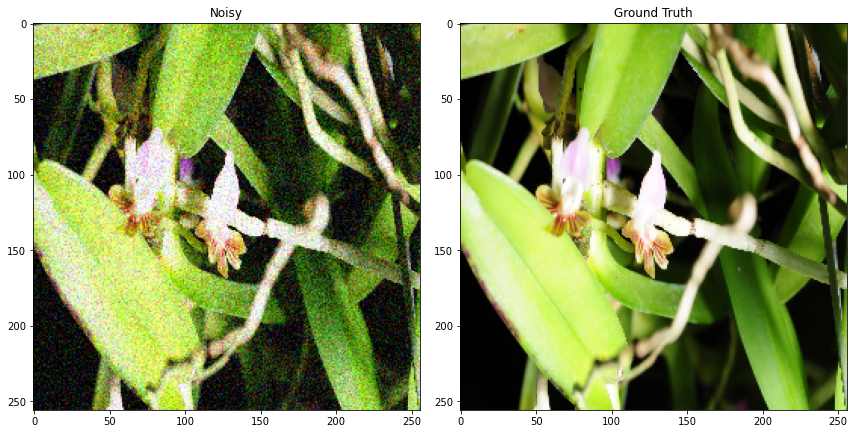

In [26]:
n = np.random.randint(0, len(train), 1)[0]
query_x, query_y = next(train_data)
query_x, query_y = query_x[0], query_y[0]
f, axarr = plt.subplots(1,2)
axarr[0].imshow(query_x)
axarr[0].title.set_text('Noisy')
axarr[1].imshow(query_y)
axarr[1].title.set_text('Ground Truth')
f.set_figwidth(12)
f.set_figheight(12)
f.tight_layout()

## Simple Auto Encoder

In [27]:
#################################################### Encoder ####################################################
inp = Input(dim)

conv1 = Conv2D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same', 
               kernel_initializer = he_normal(), name = 'C1', dilation_rate = 1)(inp)
pool1 = MaxPool2D(pool_size = 2, name = 'Pool1')(conv1)

conv2 = Conv2D(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same',
              kernel_initializer = he_normal(), name = 'C2', dilation_rate = 2)(pool1)
pool2 = MaxPool2D(pool_size = 2, name = 'Pool2')(conv2)

conv3 = Conv2D(filters = 32, kernel_size = 3, activation = 'relu', padding = 'same',
              kernel_initializer = he_normal(), name = 'C3', dilation_rate = 3)(pool2)
pool3 = MaxPool2D(pool_size = 2, name = 'Pool3')(conv3)

conv4 = Conv2D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same',
              kernel_initializer = he_normal(), name = 'C4', dilation_rate = 4)(pool3)
pool4 = MaxPool2D(pool_size = 2, name = 'Pool4')(conv4)

#################################################### Decoder ####################################################

up1 = Conv2DTranspose(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same',
              kernel_initializer = he_normal(), strides = 2, name = 'CT1')(pool4)

conc = Add()([conv4, up1])

up2 = Conv2DTranspose(filters = 32, kernel_size = 3, activation = 'relu', padding = 'same',
              kernel_initializer = he_normal(), strides = 2, name = 'CT2')(conc)

conc = Add()([conv3, up2])

up3 = Conv2DTranspose(filters = 64, kernel_size = 3, activation = 'relu', padding = 'same',
              kernel_initializer = he_normal(), strides = 2, name = 'CT3')(conc)

conc = Add()([conv2, up3])

up4 = Conv2DTranspose(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same',
              kernel_initializer = he_normal(), strides = 2, name = 'CT4')(conc)

conc = Add()([conv1, up4])

conv = Conv2D(filters = dim[-1], kernel_size = 3, activation = 'sigmoid', padding = 'same',
              kernel_initializer = he_normal(), name = 'C')(conc)

model_1 = Model(inp, conv)

opt = tf.keras.optimizers.Adam(0.0001)

model_1.compile(opt, loss = 'mae', metrics = psnr)

model_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
C1 (Conv2D)                     (None, 256, 256, 128 3584        input_1[0][0]                    
__________________________________________________________________________________________________
Pool1 (MaxPooling2D)            (None, 128, 128, 128 0           C1[0][0]                         
__________________________________________________________________________________________________
C2 (Conv2D)                     (None, 128, 128, 64) 73792       Pool1[0][0]                      
____________________________________________________________________________________________

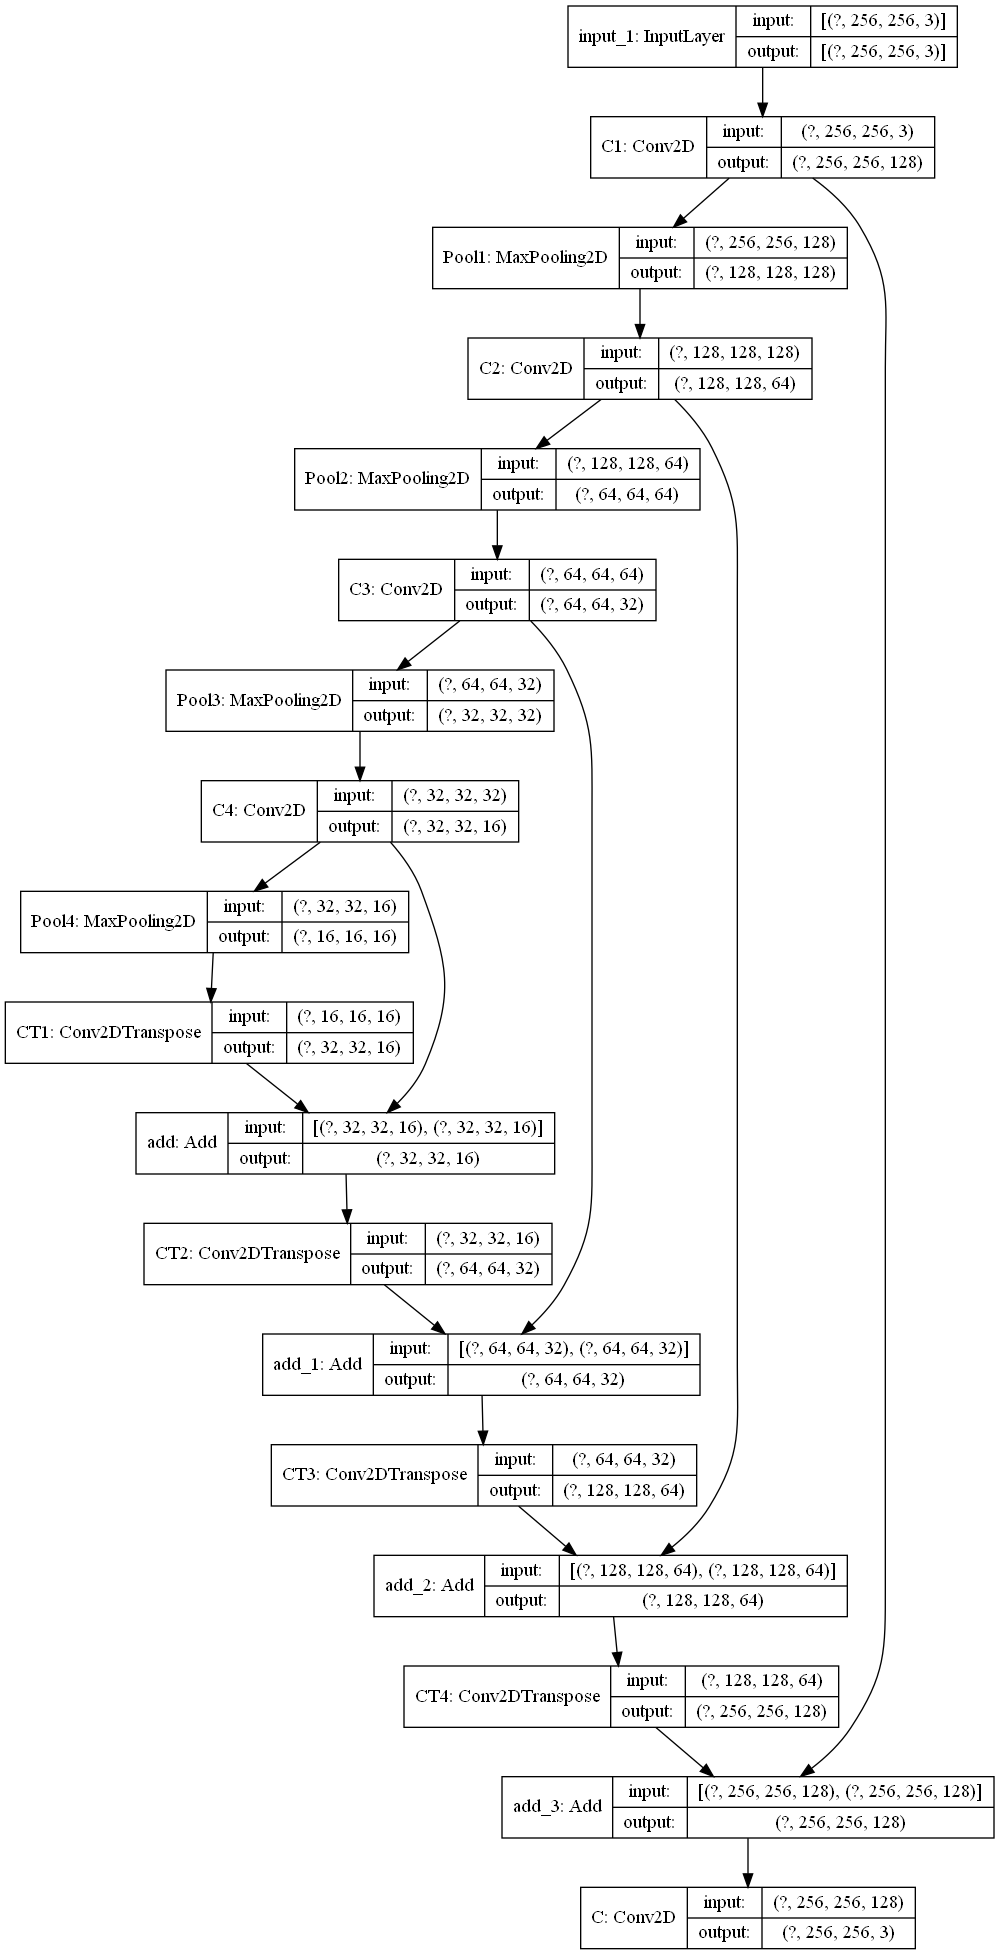

In [20]:
tf.keras.utils.plot_model(model_1, show_shapes = True)

## Training Model

In [28]:
early = EarlyStopping(restore_best_weights= True, patience = 2)
check = ModelCheckpoint('model_1.h5', save_best_only = True)
model_1.fit(train_data, epochs = 50, callbacks = [check, early], steps_per_epoch = (train.n)//bs,
            validation_data = val_data, validation_steps = (val.n)//bs)

Epoch 1/50
470/470 [==============================] - 109s 232ms/step - loss: 0.1073 - psnr: 18.0712 - val_loss: 0.0750 - val_psnr: 20.3994
Epoch 2/50
470/470 [==============================] - 104s 222ms/step - loss: 0.0653 - psnr: 21.6084 - val_loss: 0.0586 - val_psnr: 22.3760
Epoch 3/50
470/470 [==============================] - 104s 221ms/step - loss: 0.0505 - psnr: 23.6331 - val_loss: 0.0475 - val_psnr: 24.0595
Epoch 4/50
470/470 [==============================] - 104s 221ms/step - loss: 0.0410 - psnr: 25.2002 - val_loss: 0.0432 - val_psnr: 24.8638
Epoch 5/50
470/470 [==============================] - 104s 222ms/step - loss: 0.0365 - psnr: 26.1279 - val_loss: 0.0382 - val_psnr: 25.8502
Epoch 6/50
470/470 [==============================] - 110s 234ms/step - loss: 0.0340 - psnr: 26.7262 - val_loss: 0.0365 - val_psnr: 26.2368
Epoch 7/50
470/470 [==============================] - 104s 222ms/step - loss: 0.0331 - psnr: 26.9589 - val_loss: 0.0354 - val_psnr: 26.4976
Epoch 8/50
470/470 [

## Model Evaluating

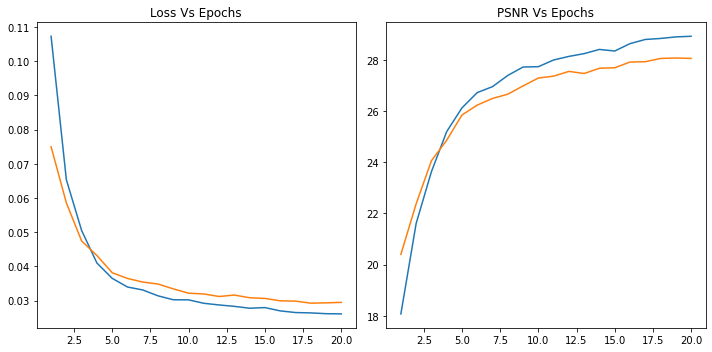

In [29]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(np.array(model_1.history.epoch)+1, model_1.history.history['loss'])
axes[0].plot(np.array(model_1.history.epoch)+1, model_1.history.history['val_loss'])
axes[0].title.set_text('Loss Vs Epochs')

axes[1].plot(np.array(model_1.history.epoch)+1, model_1.history.history['psnr'])
axes[1].plot(np.array(model_1.history.epoch)+1, model_1.history.history['val_psnr'])
axes[1].title.set_text('PSNR Vs Epochs')

fig.set_figheight(5)
fig.set_figwidth(10)
fig.tight_layout()
plt.show()

In [27]:
X, y = next(val_data)

In [28]:
model_1_score = model_1.evaluate(X, y)

1/1 [==============================] - 0s 2ms/step - loss: 0.0243 - psnr: 29.1106


## Model Prediction

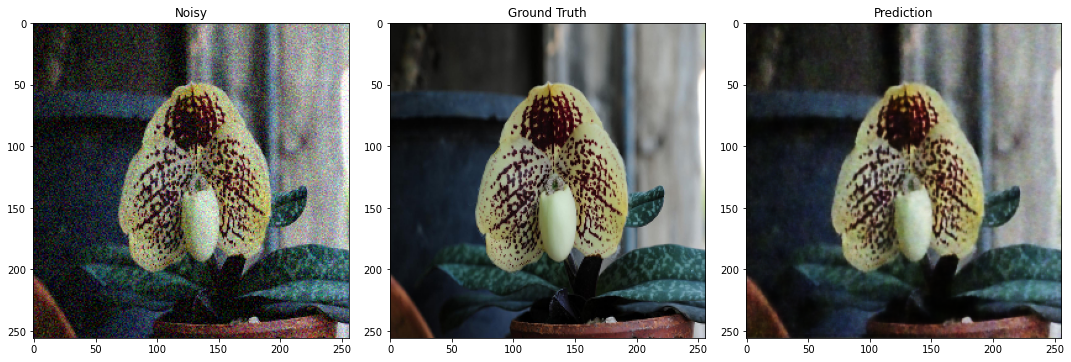

In [29]:
n = np.random.randint(0, len(X), 1)[0]

pred = model_1.predict(np.expand_dims(X[n], 0))[0]
pred = np.clip(pred, 0, 1)

f, axarr = plt.subplots(1,3)
axarr[0].imshow(X[n], cmap = 'gray')
axarr[0].title.set_text('Noisy')

axarr[1].imshow(y[n], cmap = 'gray')
axarr[1].title.set_text('Ground Truth')

axarr[2].imshow(pred, cmap = 'gray')
axarr[2].title.set_text('Prediction')

f.set_figwidth(15)
f.set_figheight(15)
f.tight_layout()
plt.show()

## UNET

In [33]:
model_2 = Unet('resnet18',input_shape = dim, encoder_freeze = True, classes = 3, decoder_block_type = 'transpose')
opt = tf.keras.optimizers.Adam(0.0001)
model_2.compile(opt, loss = 'mae', metrics = psnr)
model_2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

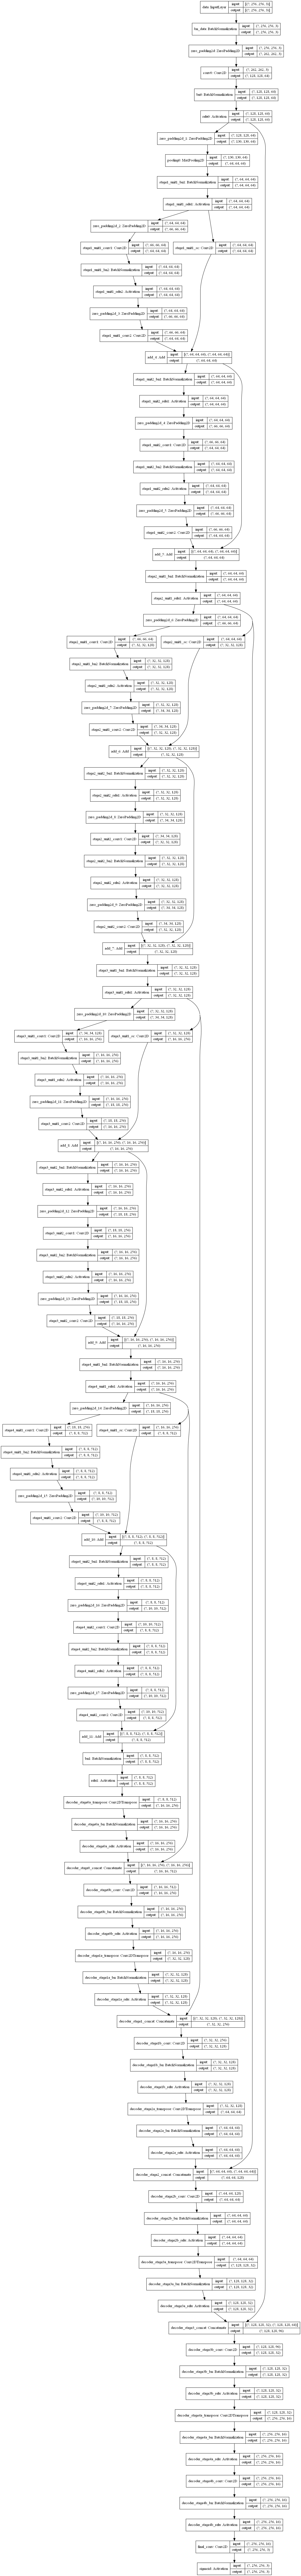

In [34]:
tf.keras.utils.plot_model(model_2, show_shapes = True)

In [35]:
early = EarlyStopping(restore_best_weights= True, patience = 3)
check = ModelCheckpoint('model_2.h5', save_best_only = True)
model_2.fit(train_data, epochs = 50, callbacks = [check,early], steps_per_epoch = (train.n)//bs, validation_data = val_data,
           validation_steps = (val.n)//bs)

Epoch 1/50
470/470 [==============================] - 104s 222ms/step - loss: 0.1113 - psnr: 18.0611 - val_loss: 0.3123 - val_psnr: 9.1406
Epoch 2/50
470/470 [==============================] - 103s 219ms/step - loss: 0.0568 - psnr: 22.4184 - val_loss: 0.1413 - val_psnr: 15.6961
Epoch 3/50
470/470 [==============================] - 103s 218ms/step - loss: 0.0529 - psnr: 23.1545 - val_loss: 0.0438 - val_psnr: 24.4324
Epoch 4/50
470/470 [==============================] - 102s 218ms/step - loss: 0.0496 - psnr: 23.6894 - val_loss: 0.0459 - val_psnr: 23.8496
Epoch 5/50
470/470 [==============================] - 103s 219ms/step - loss: 0.0465 - psnr: 24.1930 - val_loss: 0.0408 - val_psnr: 24.9372
Epoch 6/50
470/470 [==============================] - 102s 218ms/step - loss: 0.0443 - psnr: 24.5486 - val_loss: 0.0424 - val_psnr: 24.6723
Epoch 7/50
470/470 [==============================] - 102s 218ms/step - loss: 0.0434 - psnr: 24.7051 - val_loss: 0.0389 - val_psnr: 25.5470
Epoch 8/50
470/470 [=

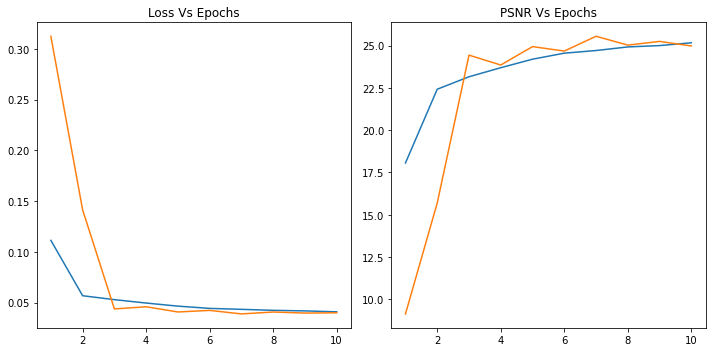

In [36]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(np.array(model_2.history.epoch)+1, model_2.history.history['loss'])
axes[0].plot(np.array(model_2.history.epoch)+1, model_2.history.history['val_loss'])
axes[0].title.set_text('Loss Vs Epochs')

axes[1].plot(np.array(model_2.history.epoch)+1, model_2.history.history['psnr'])
axes[1].plot(np.array(model_2.history.epoch)+1, model_2.history.history['val_psnr'])
axes[1].title.set_text('PSNR Vs Epochs')

fig.set_figheight(5)
fig.set_figwidth(10)
fig.tight_layout()
plt.show()

In [37]:
X, y = next(val_data)

In [30]:
model_2_score = model_2.evaluate(X, y)

1/1 [==============================] - 0s 1000us/step - loss: 0.0315 - psnr: 27.0510


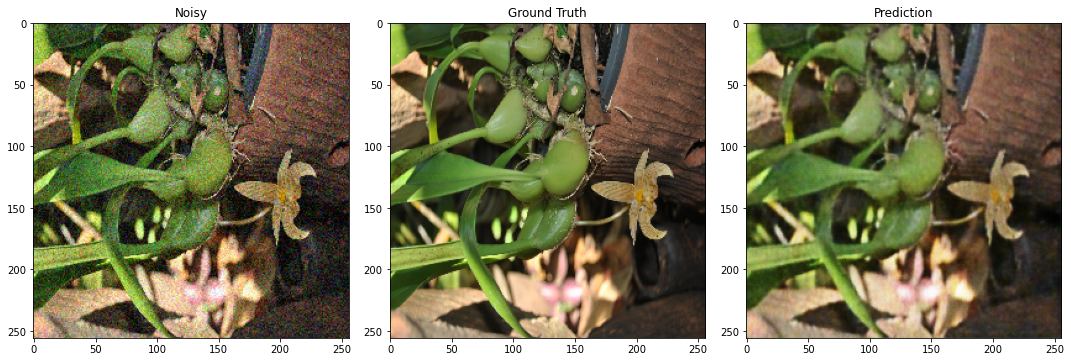

In [32]:
n = np.random.randint(0, len(X), 1)[0]

pred = model_2.predict(np.expand_dims(X[n], 0))[0]
pred = np.clip(pred, 0, 1)

f, axarr = plt.subplots(1,3)
axarr[0].imshow(X[n])
axarr[0].title.set_text('Noisy')

axarr[1].imshow(y[n])
axarr[1].title.set_text('Ground Truth')

axarr[2].imshow(pred)
axarr[2].title.set_text('Prediction')

f.set_figwidth(15)
f.set_figheight(15)
f.tight_layout()
plt.show()

### RIDNET

In [23]:
class EAM(Layer):
    def __init__(self, filters = 64, name = None, **kwargs):
        super(EAM, self).__init__()
        self.filters = filters 
        if name is not None:
            self._name = name
    def build(self, input_shape):    
        self.conv11 = Conv2D(self.filters, 3, activation =  'relu', dilation_rate = 1, padding = 'same', name = 'C11')
        self.conv12 = Conv2D(self.filters, 3, activation =  'relu', dilation_rate = 2, padding = 'same', name = 'C12')

        self.conv21 = Conv2D(self.filters, 3, activation =  'relu', dilation_rate = 3, padding = 'same', name = 'C21')
        self.conv22 = Conv2D(self.filters, 3, activation =  'relu', dilation_rate = 4, padding = 'same', name = 'C22')

        self.conc = Concatenate(-1, name = 'Concat')

        self.conv31 = Conv2D(self.filters, 3, activation =  'relu', padding = 'same', name = 'C31')

        self.resi_1 = Add(name = 'Residual_1')

        self.conv41 = Conv2D(self.filters, 3, activation =  'relu', padding = 'same', name = 'C41')
        self.conv42 = Conv2D(self.filters, 3, activation =  None, padding = 'same', name = 'C42')

        self.resi_2 = Add(name = 'Residual_2')

        self.conv51 = Conv2D(self.filters, 3, activation =  'relu', padding = 'same', name = 'C51')
        self.conv52 = Conv2D(self.filters, 3, activation =  'relu', padding = 'same', name = 'C52')
        self.conv61 = Conv2D(self.filters, 1, activation =  None, padding = 'same', name = 'C61')

        self.resi_3 = Add(name = 'Residual_3')

        self.glob = GlobalAveragePooling2D(name = 'Global_Pool')

        self.reshape = Reshape((1, 1, self.filters), name = 'Reshape')

        self.conv71 = Conv2D(4, 3, activation =  'relu', padding = 'same', name = 'C71')
        self.conv72 = Conv2D(self.filters, 3, activation =  'sigmoid', padding = 'same', name = 'C72')

        self.mul = Multiply(name = 'Multiply')

        self.resi_4 = Add(name = 'Residual_4')
    def call(self, inp):
        conv11 = self.conv11(inp)
        conv12 = self.conv12(conv11)

        conv21 = self.conv21(inp)
        conv22 = self.conv22(conv21)
        conc = self.conc([conv12, conv22])

        conv31 = self.conv31(conc)
        resi_1 = self.resi_1([conv31, inp])

        conv41 = self.conv41(resi_1)
        conv42 = self.conv42(conv41)
        
        resi_2 = self.resi_2([resi_1, conv42])
        resi_2 = Activation('relu')(resi_2)

        conv51 = self.conv51(resi_2)
        conv52 = self.conv52(conv51)
        conv61 = self.conv61(conv52)

        resi_3 = self.resi_3([resi_2, conv61])
        resi_3 = Activation('relu')(resi_3)

        glob = self.glob(resi_3)

        reshape = self.reshape(glob)

        conv71 = self.conv71(reshape)
        conv72 = self.conv72(conv71)

        mul = self.mul([resi_3, conv72])
        
        resi_4 = self.resi_4([inp, mul])
        return resi_4
    
    def get_config(self): #https://stackoverflow.com/questions/58678836/notimplementederror-layers-with-arguments-in-init-must-override-get-conf/58799021
        config = super().get_config().copy()
        config.update({'filter_size' : self.filters})
        return config

In [7]:
def scheduler(epoch, lr):
    return lr*0.5

In [8]:
inp = Input(shape = (dim), name = 'Input')
feat = Conv2D(64, 3, activation =  'relu', padding = 'same', name = 'Feature_Ext')(inp)
eam = EAM(name = 'EAM_1')(feat)
eam = EAM(name = 'EAM_2')(eam)
eam = EAM(name = 'EAM_3')(eam)
lsc = Add(name = 'LSC_1')([eam, feat])
out = Conv2D(3, 3, padding = 'same', name = 'Out')(lsc)
lsc = Add(name = 'LSC_2')([out, inp])
model_3 = Model(inp, lsc)
opt = tf.keras.optimizers.Adam(0.0001)
model_3.compile('adam', loss = 'mae', metrics = psnr)
model_3.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Feature_Ext (Conv2D)            (None, 256, 256, 64) 1792        Input[0][0]                      
__________________________________________________________________________________________________
EAM_1 (EAM)                     (None, 256, 256, 64) 378052      Feature_Ext[0][0]                
__________________________________________________________________________________________________
EAM_2 (EAM)                     (None, 256, 256, 64) 378052      EAM_1[0][0]                      
______________________________________________________________________________________________

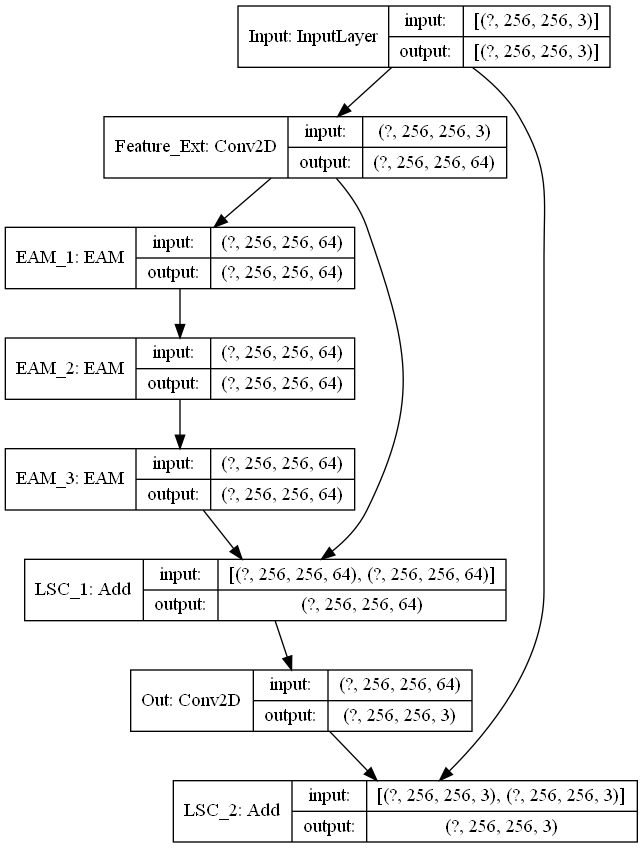

In [24]:
tf.keras.utils.plot_model(model_3, show_shapes = True)

In [9]:
bs = 4
train = train_gen.flow_from_directory(train_dir, class_mode = None, target_size = (img_h, img_w), batch_size = bs)

val = val_gen.flow_from_directory(val_dir, class_mode = None, target_size = (img_h, img_w), batch_size = bs)

train_data = noisy_generator(train)
val_data = noisy_generator(val)

Found 2820 images belonging to 52 classes.
Found 739 images belonging to 52 classes.


In [10]:
early = EarlyStopping(restore_best_weights= True, patience = 2)
check = ModelCheckpoint('model_3.h5', save_best_only = True)
sch = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model_3.fit(train_data, steps_per_epoch = (train.n)//bs, epochs = 50, callbacks = [early, check, sch],
            validation_data = val_data, validation_steps = (val.n)//bs)

Epoch 1/50
705/705 [==============================] - 464s 659ms/step - loss: 0.0386 - psnr: 26.9821 - val_loss: 0.0299 - val_psnr: 28.1995 - lr: 5.0000e-04
Epoch 2/50
705/705 [==============================] - 459s 651ms/step - loss: 0.0249 - psnr: 29.6308 - val_loss: 0.0268 - val_psnr: 29.0585 - lr: 2.5000e-04
Epoch 3/50
705/705 [==============================] - 459s 651ms/step - loss: 0.0231 - psnr: 30.2097 - val_loss: 0.0251 - val_psnr: 29.6185 - lr: 1.2500e-04
Epoch 4/50
705/705 [==============================] - 459s 651ms/step - loss: 0.0224 - psnr: 30.4390 - val_loss: 0.0251 - val_psnr: 29.6112 - lr: 6.2500e-05
Epoch 5/50
705/705 [==============================] - 459s 652ms/step - loss: 0.0218 - psnr: 30.6660 - val_loss: 0.0245 - val_psnr: 29.7816 - lr: 3.1250e-05
Epoch 6/50
705/705 [==============================] - 459s 651ms/step - loss: 0.0216 - psnr: 30.7101 - val_loss: 0.0239 - val_psnr: 30.0139 - lr: 1.5625e-05
Epoch 7/50
705/705 [==============================] - 459s

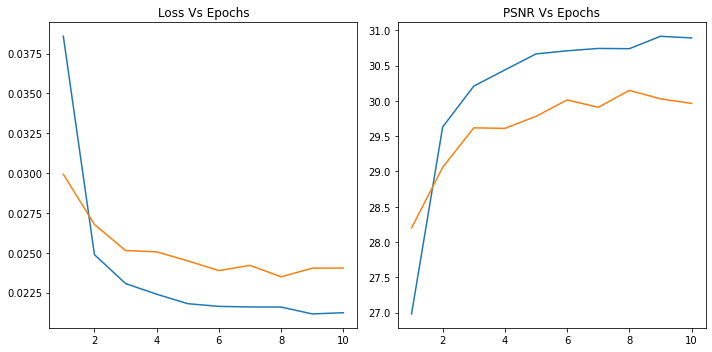

In [11]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(np.array(model_3.history.epoch)+1, model_3.history.history['loss'])
axes[0].plot(np.array(model_3.history.epoch)+1, model_3.history.history['val_loss'])
axes[0].title.set_text('Loss Vs Epochs')

axes[1].plot(np.array(model_3.history.epoch)+1, model_3.history.history['psnr'])
axes[1].plot(np.array(model_3.history.epoch)+1, model_3.history.history['val_psnr'])
axes[1].title.set_text('PSNR Vs Epochs')

fig.set_figheight(5)
fig.set_figwidth(10)
fig.tight_layout()
plt.show()

In [17]:
X, y = next(val_data)

In [33]:
model_3_score = model_3.evaluate(X, y)

1/1 [==============================] - 0s 1000us/step - loss: 0.0199 - psnr: 31.0902


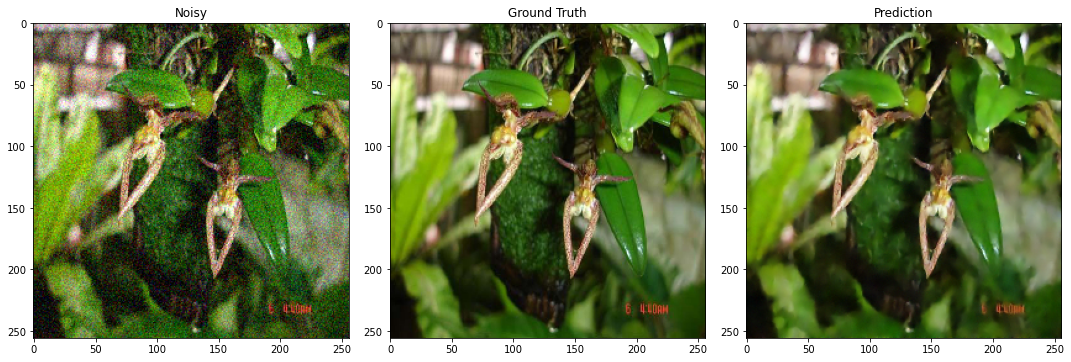

In [34]:
n = np.random.randint(0, len(X), 1)[0]

pred = model_3.predict(np.expand_dims(X[n], 0))[0]
pred = np.clip(pred, 0, 1)

f, axarr = plt.subplots(1,3)
axarr[0].imshow(X[n])
axarr[0].title.set_text('Noisy')

axarr[1].imshow(y[n])
axarr[1].title.set_text('Ground Truth')

axarr[2].imshow(pred)
axarr[2].title.set_text('Prediction')

f.set_figwidth(15)
f.set_figheight(15)
f.tight_layout()
plt.show()

model_3 = load_model('model_3.h5', compile = False, custom_objects = {'EAM' : EAM})
opt = tf.keras.optimizers.Adam(0.0001)
model_3.compile(opt, loss = 'mae', metrics = psnr)

In [36]:
x = PrettyTable()
x.field_names = ['Model', 'Val Loss', 'PSNR']
x.add_row(['AutoEncoder', model_1_score[0], model_1_score[1]])
x.add_row(['-'*20, '-'*20, '-'*20])
x.add_row(['UNET', model_2_score[0], model_2_score[1]])
x.add_row(['-'*20, '-'*20, '-'*20])
x.add_row(['EAM', model_3_score[0], model_3_score[1]])
print(x)

+----------------------+----------------------+----------------------+
|        Model         |       Val Loss       |         PSNR         |
+----------------------+----------------------+----------------------+
|     AutoEncoder      | 0.02431689016520977  |  29.11060905456543   |
| -------------------- | -------------------- | -------------------- |
|         UNET         |  0.0314917154610157  |  27.05096435546875   |
| -------------------- | -------------------- | -------------------- |
|         EAM          | 0.01994105987250805  |  31.090194702148438  |
+----------------------+----------------------+----------------------+
